# Setup

In [ ]:
!pip install opencv-contrib-python
!pip install keras-tuner --upgrade
!pip install scikeras
!pip install tensorflow-addons

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
import datetime
import os
import shutil
import pickle
import keras_tuner
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [ ]:
# Upload kaggle credentials here
from google.colab import files
files.upload()

In [ ]:
# Download datasets and SR models
!wget -O fer2013.csv https://media.githubusercontent.com/media/julietlawton/emotion-recognition/main/fer2013/fer2013.csv
!wget -O LapSRN_x2.pb https://github.com/fannymonori/TF-LapSRN/raw/master/export/LapSRN_x2.pb
!wget -O LapSRN_x4.pb https://github.com/fannymonori/TF-LapSRN/raw/master/export/LapSRN_x4.pb
!wget -O LapSRN_x8.pb https://github.com/fannymonori/TF-LapSRN/raw/master/export/LapSRN_x8.pb
!wget -O fer_preprocessed_2xres.pkl.zip https://media.githubusercontent.com/media/julietlawton/emotion-recognition/main/datasets/fer_preprocessed_2xres.pkl.zip


In [ ]:
# Unzip preprocessed dataset
!unzip fer_preprocessed_2xres.pkl.zip

In [ ]:
# Verify download worked
!head fer2013.csv

In [ ]:
# Kaggle setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!pip install -q kaggle
!pip install -q kaggle-cli

# EDA and Preprocessing

In [8]:
# Read in dataset and examine its attributes
fer_df = pd.read_csv('fer2013.csv')
fer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [9]:
# Drop the usage column because we don't need it
fer_df.drop(['Usage'], axis=1, inplace=True)

In [10]:
# Map the emotion integer encoding to labels
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}
NUM_CLASSES = 7

In [ ]:
# Supplementing emotion images
path = './random-images-for-face-emotion-recognition'
!kaggle datasets download -d sudarshanvaidya/random-images-for-face-emotion-recognition
!unzip random-images-for-face-emotion-recognition.zip -d random-images-for-face-emotion-recognition

dirs = os.listdir(path)
for dir in dirs:
    # Keep all folders except for contempt
    if dir == 'contempt':
        dir_path = os.path.join(path, dir)
        # Remove folder
        shutil.rmtree(dir_path)

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

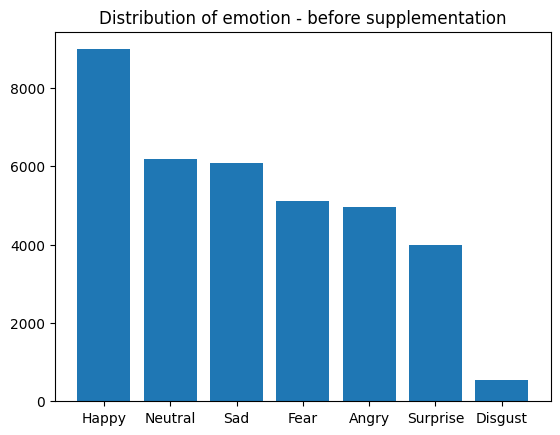

In [15]:
# Examine distribution of emotion class labels before supplementation
emotion_counts = fer_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.title("Distribution of emotion - before supplementation")
plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

images - 2020-11-06T000532.711_face.png


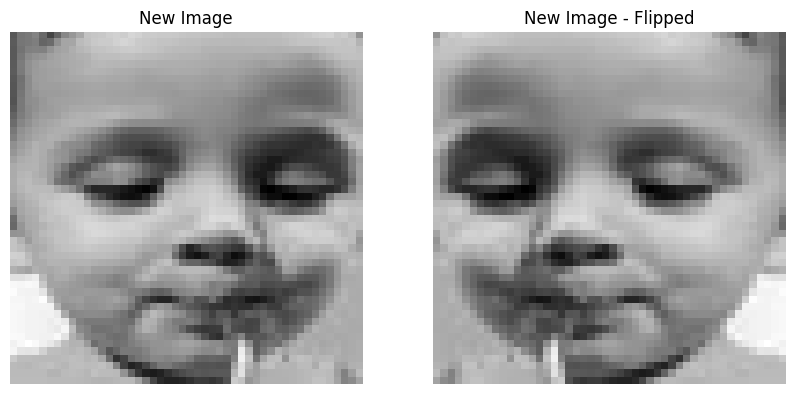

In [16]:
# Get directories for each emotion
angry_dir = os.path.join(path, 'anger')
disgust_dir = os.path.join(path, 'disgust')
fear_dir = os.path.join(path, 'fear')
happy_dir = os.path.join(path, 'happiness')
sad_dir = os.path.join(path, 'sadness')
surprise_dir = os.path.join(path, 'surprise')
neutral_dir = os.path.join(path, 'neutrality')

image_dirs = [angry_dir, disgust_dir, fear_dir, happy_dir, sad_dir, surprise_dir, neutral_dir]

# Test one image
disgust_images = os.listdir(disgust_dir)
print(disgust_images[0])
image_path = os.path.join(disgust_dir, disgust_images[0])
image = Image.open(image_path)
image = image.convert('L')
image = image.resize((48, 48))
image_array = np.array(image)
image_flipped = np.fliplr(image_array)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("New Image")
plt.imshow(image_array, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("New Image - Flipped")
plt.imshow(image_flipped, cmap='gray')
plt.axis('off')
plt.show()

In [17]:
# Add more samples for all emotions except happy
new_images = []

# We can count in order because the directories are in the same order as the labels
emotion_label_int = 0

# For each directory, add the images to the appropriate class
for dir in image_dirs:
  images = os.listdir(dir)
  # Skip happiness because it is overrepresented
  if emotion_label_int != 3:
    for image_file in images:
        image_path = os.path.join(dir, image_file)

        image = Image.open(image_path)
        image = image.convert('L')
        image = image.resize((48, 48))
        image_array = np.array(image)

        pixel_string = ' '.join(map(str, image_array.flatten()))
        new_row = {'emotion': emotion_label_int, 'pixels': pixel_string}
        new_images.append(new_row)

  emotion_label_int += 1

new_images_df = pd.DataFrame(new_images)

fer_df = pd.concat([fer_df, new_images_df], ignore_index=True)


Happy       8989
Sad         6823
Neutral     6722
Angry       5843
Fear        5691
Surprise    4777
Disgust      986
Name: emotion, dtype: int64

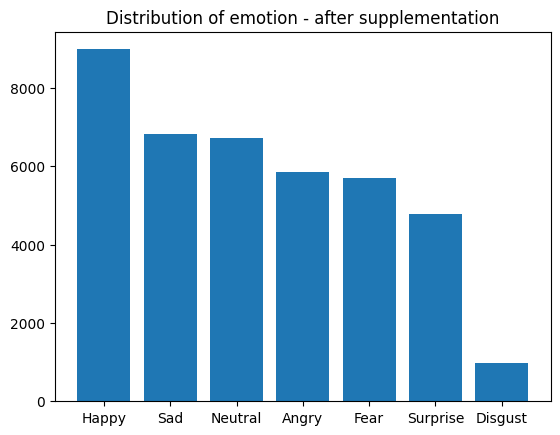

In [18]:
# Examine distribution of emotion class labels after augmentation
emotion_counts = fer_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.title("Distribution of emotion - after supplementation")
plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

In [ ]:
# Convert pixel strings to numpy arrays, reshape, and normalize
fer_df['pixels'] = fer_df['pixels'].apply(lambda img: np.array(img.split(' ')).reshape(48, 48).astype('float32')/255.0)
print(fer_df['pixels'].iloc[0].shape)

(48, 48)


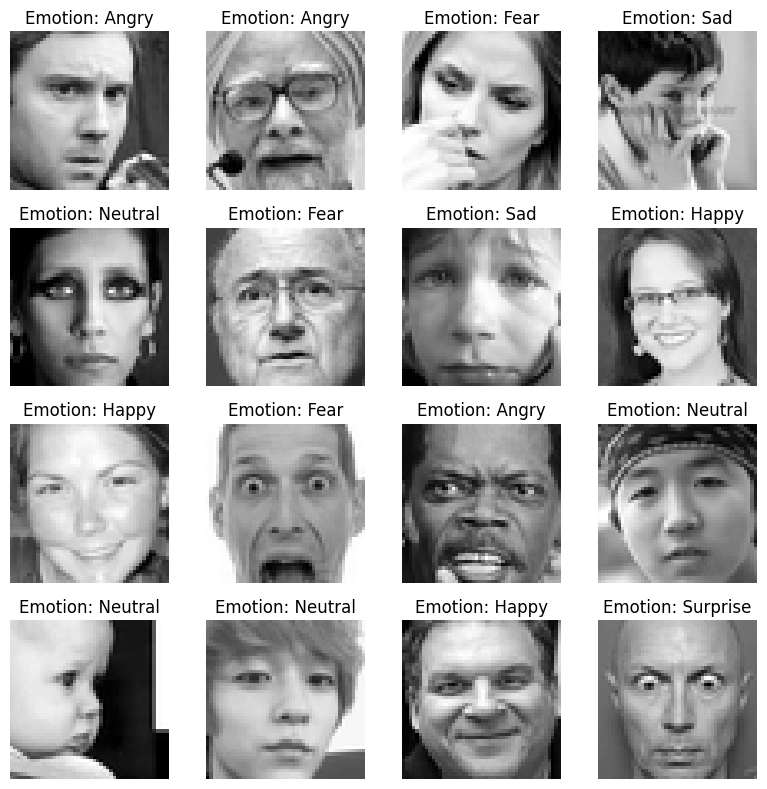

In [ ]:
# Display the first few images in grayscale
fig = plt.figure(figsize=(8,8))
for i in range(16):
    img = fer_df['pixels'].iloc[i]
    emotion = emotion_mapping[fer_df['emotion'].iloc[i]]
    plt.subplot(4,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Emotion: {emotion}")
    plt.axis('off')

fig.tight_layout()
plt.show()

New shape: (96, 96)


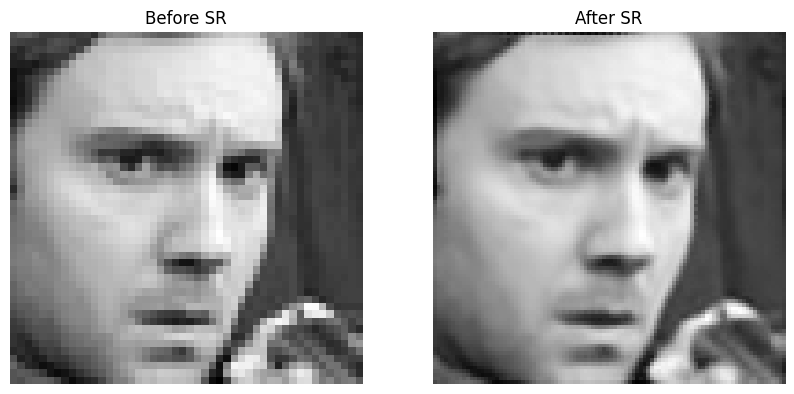

In [ ]:
# Use super-resolution to make the images higher resolution
sr = cv2.dnn_superres.DnnSuperResImpl_create()
scale = 2
path = 'LapSRN_x2.pb'
sr.readModel(path)
sr.setModel('lapsrn', scale)

def improve_resolution(img):
    # Convert image to be 8-bit
    image_uint8 = (img * 255).astype('uint8')

    # Use the model to upsample the image
    result = sr.upsample(image_uint8)

    # Normalize the output again
    result_normalized = result.astype('float32') / 255.0
    return result_normalized

# Test on one sample
sample_image = fer_df['pixels'].iloc[0]
sr_image = improve_resolution(sample_image)
print(f"New shape: {sr_image.shape}")

fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Before SR")
plt.imshow(sample_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After SR")
plt.imshow(sr_image, cmap='gray')
plt.axis('off')
plt.show()

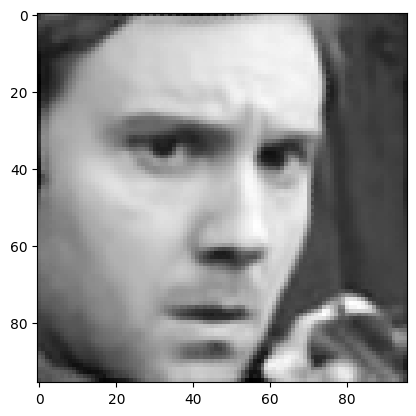

In [ ]:
# Apply to all images
fer_df['pixels'] = fer_df['pixels'].apply(improve_resolution)

# Check that it worked
plt.imshow(fer_df['pixels'].iloc[0], cmap='gray')
plt.show()

In [ ]:
# Set image size
INPUT_SIZE = fer_df['pixels'].iloc[0].shape[0]

In [ ]:
# Reshape the images to make the single color channel explicit for conversion to dataset later
fer_df['pixels'] = fer_df['pixels'].apply(lambda img: img.reshape(INPUT_SIZE, INPUT_SIZE, 1))
fer_df['pixels'].iloc[0].shape

(96, 96, 1)

In [ ]:
# Set preprocessed dataset filename
DATASET_FILENAME = "fer_preprocessed_2xres.pkl"

In [ ]:
# Serialize dataset to avoid re-running preprocessing operations
with open(DATASET_FILENAME, "wb") as f:
  pickle.dump(fer_df, f)

In [ ]:
# Load dataset
with open(DATASET_FILENAME, "rb") as f:
  fer_df = pickle.load(f)

In [ ]:
print(len(fer_df))

39831


In [ ]:
# Duplicate grayscale channel 3 times to get input to be the right dimensions for the pretrained model
# NOTE: Only run this if using a pretrained model

# fer_df['pixels'] = fer_df['pixels'].apply(lambda img: np.repeat(img, 3, axis=2))
# fer_df['pixels'].iloc[0].shape

(96, 96, 3)

# Model Selection and Training

In [ ]:
# Partition data into train, test, and validation splits
train_df, test_df = train_test_split(fer_df, test_size=0.4, shuffle=True)
test_df, val_df = train_test_split(test_df, test_size=0.5, shuffle=True)

In [ ]:
# Examine sample counts for each split
print(train_df.info())
print(test_df.info())
print(val_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23898 entries, 30752 to 29493
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  23898 non-null  int64 
 1   pixels   23898 non-null  object
dtypes: int64(1), object(1)
memory usage: 560.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7966 entries, 17158 to 39239
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  7966 non-null   int64 
 1   pixels   7966 non-null   object
dtypes: int64(1), object(1)
memory usage: 186.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7967 entries, 13296 to 3404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  7967 non-null   int64 
 1   pixels   7967 non-null   object
dtypes: int64(1), object(1)
memory usage: 186.7+ KB
None


Happy       5349
Sad         4107
Neutral     4058
Angry       3503
Fear        3371
Surprise    2895
Disgust      615
Name: emotion, dtype: int64

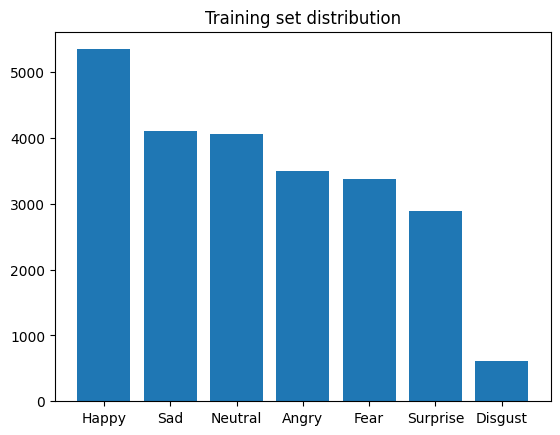

In [ ]:
# Visually inspect the training and validation distribution to make sure they are similar
emotion_counts = train_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.title("Training set distribution")
plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

Happy       1791
Sad         1369
Neutral     1355
Angry       1165
Fear        1153
Surprise     958
Disgust      176
Name: emotion, dtype: int64

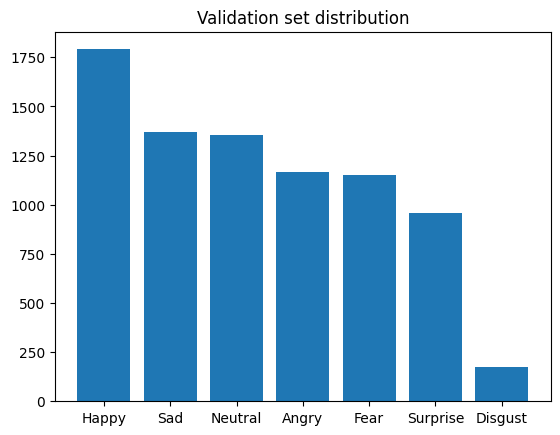

In [ ]:
# Visually inspect the training and validation distribution to make sure they are similar
emotion_counts = val_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.title("Validation set distribution")
plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

In [ ]:
# Compute class weights for unbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['emotion']), y=train_df['emotion'])
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.9732041049030786, 1: 5.906574394463668, 2: 0.9985375840889149, 3: 0.6396852164137156, 4: 0.823245719797444, 5: 1.1874782608695653, 6: 0.8463063956370848}


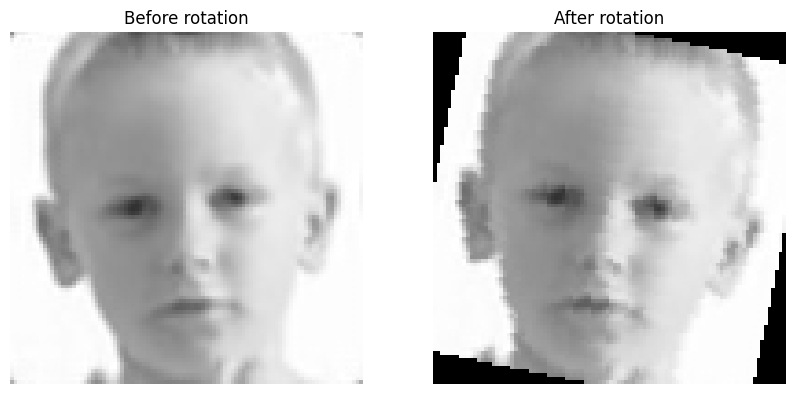

In [ ]:
# Test rotation operation
test_image = tf.convert_to_tensor(train_df['pixels'].iloc[0], dtype=tf.float32)
rotation_angle = tf.random.uniform([], minval=-15, maxval=15, dtype=tf.float32)
rotated_test_image = tfa.image.rotate(test_image, np.deg2rad(rotation_angle))

fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title("Before rotation")
plt.imshow(test_image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After rotation")
plt.imshow(rotated_test_image, cmap='gray')
plt.axis('off')
plt.show()


In [42]:
# Define data generator for training set with augmentation operations
def train_data_generator(df):
  for _, row in df.iterrows():
    image = tf.convert_to_tensor(row['pixels'], dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    label = tf.convert_to_tensor(row['emotion'], dtype=tf.int64)
    yield (image, label)


In [43]:
# Define test and validation data generator
def test_val_data_generator(df):
  for _, row in df.iterrows():
    image = tf.convert_to_tensor(row['pixels'], dtype=tf.float32)
    label = tf.convert_to_tensor(row['emotion'], dtype=tf.int64)
    yield (image, label)


In [ ]:
# Set buffer size for shuffle and batch size for training
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [44]:
# Create tf datasets for each split
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data_generator(train_df),
    output_types=(tf.float32, tf.int64),
    output_shapes=([INPUT_SIZE, INPUT_SIZE, 1], [])
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: test_val_data_generator(val_df),
    output_types=(tf.float32, tf.int64),
    output_shapes=([INPUT_SIZE, INPUT_SIZE, 1], [])
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_val_data_generator(test_df),
    output_types=(tf.float32, tf.int64),
    output_shapes=([INPUT_SIZE, INPUT_SIZE, 1], [])
).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


(96, 96, 3)


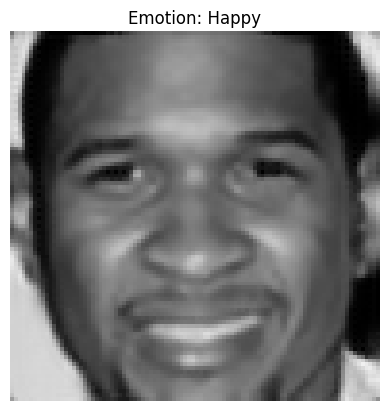

In [ ]:
# Check that conversion worked
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch[0].shape)
    plt.title(f"Emotion: {emotion_mapping[label_batch[0].numpy()]}")
    plt.imshow(img_batch[0], cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# Create helper function for plotting learning curves
def learning_curve(hist):
  plt.subplot(2,1,1)
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("learning curve - accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(["train", "test"], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(hist.history["loss"])
  plt.plot(hist.history["val_loss"])
  plt.title("learning curve - loss")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.legend(["train", "test"], loc='upper right')
  plt.subplots_adjust(hspace=0.8)
  plt.show()

In [1]:
# Define a hyper model to run a hyperparameter search
def build_hypermodel(hp):
  model = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Conv2D(96, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    # Provide value range for hyperparameters to consider
    Dense(units=hp.Int('units', min_value=960, max_value=1856, step=64), activation='relu'),
    Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.8, step=0.1)),
    Dense(NUM_CLASSES, activation='softmax')
  ])
  model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

# Define a keras tuner to find ideal hyperparameters for this model
tuner = keras_tuner.Hyperband(
    hypermodel=build_hypermodel,
    objective='val_accuracy',
    max_epochs=20,
    directory='tuner_output',
    project_name='hp_search'
)

# Run the search
tuner.search(
    x=train_dataset,
    epochs=20,
    validation_data=val_dataset,
    batch_size=BATCH_SIZE
)

In [50]:
# Retrieve the best hyperparameters from the run
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print(best_hyperparameters)

# Retrieve the best model and evaluate
best_model = tuner.get_best_models(num_models=1)[0]
scores = best_model.evaluate(test_dataset)
print("Accuracy: %.2f%%" % (scores[1]*100))

{'units': 1664, 'dropout': 0.30000000000000004, 'learning_rate': 0.001, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}
125/125 [==============================] - 7s 48ms/step - loss: 1.1319 - accuracy: 0.5965
Accuracy: 59.65%


In [ ]:
# Continue training best model from Hyperband search
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=3, verbose=1)

# Train for an additional 10 epochs to see if performance improves
model = tuner.get_best_models(num_models=1)[0]
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [60]:
# Train a new model with the best hyperparameters
model = tuner.hypermodel.build(tuner.get_best_hyperparameters(num_trials=1)[0])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[es])
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
374/374 [==============================] - 75s 178ms/step - loss: 2.2836 - accuracy: 0.2773 - val_loss: 1.8321 - val_accuracy: 0.2199
Epoch 2/50
374/374 [==============================] - 71s 176ms/step - loss: 1.5869 - accuracy: 0.3751 - val_loss: 1.5447 - val_accuracy: 0.4037
Epoch 3/50
374/374 [==============================] - 71s 176ms/step - loss: 1.4518 - accuracy: 0.4375 - val_loss: 1.3399 - val_accuracy: 0.4853
Epoch 4/50
374/374 [==============================] - 70s 175ms/step - loss: 1.3656 - accuracy: 0.4765 - val_loss: 1.2602 - val_accuracy: 0.5253
Epoch 5/50
374/374 [==============================] - 71s 176ms/step - loss: 1.2938 - accuracy: 0.5028 - val_loss: 1.2204 - val_accuracy: 0.5459
Epoch 6/50
374/374 [==============================] - 70s 175ms/step - loss: 1.2612 - accuracy: 0.5211 - val_loss: 1.1814 - val_accuracy: 0.5552
Epoch 7/50
374/374 [==============================] - 70s 176ms/step - loss: 1.2206 - accuracy: 0.5385 - val_loss: 1.2305 - val_ac

125/125 [==============================] - 6s 48ms/step - loss: 1.1676 - accuracy: 0.6052
Accuracy: 60.52%


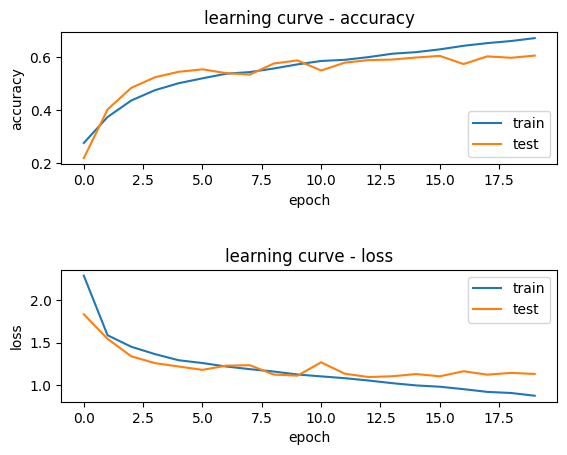

In [61]:
# Get test accuracy and plot learning curves
scores = model.evaluate(test_dataset)
print("Accuracy: %.2f%%" % (scores[1]*100))
learning_curve(history)

In [83]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        320       
                                                                 
 batch_normalization_10 (Ba  (None, 94, 94, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 92, 92, 64)        18496     
                                                                 
 batch_normalization_11 (Ba  (None, 92, 92, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                      

In [66]:
# Save trained model and summary
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# model.save("modelv3.keras")

# Model Evalutation

In [3]:
# Generate prediction for a single image
for img, label in val_dataset.take(1):
    print(img[0].shape)
    first_img = img[0]
    first_img_batch = np.expand_dims(first_img, axis=0)
    print(first_img_batch.shape)
    plt.title(f"Emotion: {emotion_mapping[label[0].numpy()]}")
    plt.imshow(first_img, cmap='gray')
    plt.axis('off')
    plt.show()
    prediction = model.predict(first_img_batch)

print(prediction)
print(emotion_mapping[np.argmax(prediction)])
print(np.max(prediction))

In [ ]:
# Generate model predictions for the test set
correct = 0
total = 0

true_labels = []
predicted_labels = []

# For each batch, collect the model predictions and true labels
for img_batch, label_batch in test_dataset:
    predictions = model.predict(img_batch)
    predicted = np.argmax(predictions, axis=1)

    true_labels.extend(label_batch.numpy())
    predicted_labels.extend(predicted)

    # Count correct predictions
    for i in range(len(img_batch)):
        if predicted[i] == label_batch[i].numpy():
            correct += 1
        total += 1

# Display accuracy for this run
print(correct/total)

In [ ]:
# Define class labels for classification report and confusion matrix
class_labels = list(emotion_mapping.values())
print(class_labels)

In [ ]:
# Create a classification report to get performance metrics broken down by class
report = classification_report(true_labels, predicted_labels, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
report_df = report_df.reset_index().rename(columns={'index': 'class_name'})
report_df = report_df.sort_values("support", ascending=False).reset_index(drop=True)
display(report_df)


# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
plt.imshow(cm)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.show()

In [ ]:
# Compute accuracy by class
accuracies = np.diag(cm) / np.sum(cm, axis=1)

class_accuracies = list(zip(class_labels, accuracies))
class_accuracies = sorted(class_accuracies, key=lambda x:x[1], reverse=True)
print(class_accuracies)

# Experiments

In [ ]:
# Undersample the happy class since it is overrepresented
happy = fer_df[fer_df['emotion'] == 3]
happy_undersampled = happy.sample(6200)

fer_df = fer_df.drop(happy.index)

fer_df = pd.concat([fer_df, happy_undersampled], ignore_index=True)

# Check new distribution
emotion_counts = fer_df['emotion'].value_counts()
emotion_counts = emotion_counts.rename(lambda x: emotion_mapping[x])

display(emotion_counts)

plt.title("Distribution of emotion - after undersampling")
plt.bar(emotion_counts.index, emotion_counts.values)
plt.show()

In [ ]:
# Run this code to remove the disgust class
fer_df.drop(fer_df[fer_df['emotion'] == 1].index, inplace=True)

category_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
fer_df['emotion'] = fer_df['emotion'].map(category_mapping)

emotion_mapping = {
    0: 'Angry',
    1: 'Fear',
    2: 'Happy',
    3: 'Sad',
    4: 'Surprise',
    5: 'Neutral'
}
NUM_CLASSES = 6

In [ ]:
# Pre-trained Model Exploration
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Optimizer
from tensorflow.data import Dataset
from tensorflow.keras import Model
from tensorflow.keras.callbacks import History

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet


def set_model(
        base_model,
        train_dataset,
        num_classes: int,
        frozen_layers: int
):
    for images, _ in train_dataset.take(1):
        input_shape = images[0].shape

    base_model = base_model(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
    )
    base_model.trainable = True
    for layer in base_model.layers[:frozen_layers]:
        layer.trainable = False

    inputs = tf.keras.Input(input_shape)

    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(
        2048,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.02)
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=regularizers.l2(0.02)
    )(x)
    model = tf.keras.Model(inputs, outputs)

    return model


def train_model(
    model: Model,
    train_dataset: Dataset,
    val_dataset: Dataset,
    optimizer: Optimizer=Adam,
    initial_lr: float = 1e-4,
    max_lr: float = 1e-2,
    epochs: int = 50
) -> Tuple[Model, History]:

    step_size = 2000
    cyclic_lr = CyclicalLearningRate(
        initial_learning_rate=initial_lr,
        maximal_learning_rate=max_lr,
        step_size=step_size,
        scale_fn=lambda x: 1.,
        scale_mode='cycle')

    def scheduler(epoch, lr=initial_lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)


    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        return image, label


    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    callbacks = [
        LearningRateScheduler(scheduler, verbose=1),
        EarlyStopping(monitor='val_loss', patience=10)
    ]

    train_dataset = train_dataset.map(augment)

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )

    return model, history

In [ ]:
resnet_model = set_model(ResNet50, train_dataset, num_classes=NUM_CLASSES, frozen_layers=1000)
resnet_model, resnet_history = train_model(resnet_model, train_dataset, val_dataset)

densenet_model = set_model(DenseNet201, train_dataset, num_classes=NUM_CLASSES, frozen_layers=1000)
densenet_model, densenet_history = train_model(densenet_model, train_dataset, val_dataset)

inception_model = set_model(InceptionV3, train_dataset, num_classes=NUM_CLASSES, frozen_layers=1000)
inception_model, inception_history = train_model(inception_model, train_dataset, val_dataset)

mobilenet_model = set_model(MobileNet, train_dataset, num_classes=NUM_CLASSES, frozen_layers=1000)
mobilenet_model, mobilenet_history = train_model(mobilenet_model, train_dataset, val_dataset)

In [ ]:
def evaluate_models(models, test_dataset):
    for i, model in enumerate(models):
        scores = model.evaluate(test_dataset)
        print(f"Accuracy of model {i+1}: {scores[1]*100:.2f}%")


evaluate_models(
    [resnet_model, densenet_model, inception_model, mobilenet_model],
    test_dataset
)

In [ ]:
def learning_curves(histories, labels):
    for i, history in enumerate(histories):
        plt.subplot(2,1,1)
        plt.plot(history.history["accuracy"], label=f'{labels[i]} Training Accuracy')
        plt.plot(history.history["val_accuracy"], label=f'{labels[i]} Validation Accuracy')
        plt.title("learning curve - accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")

        plt.subplot(2,1,2)
        plt.plot(history.history["loss"], label=f'{labels[i]} Training Loss')
        plt.plot(history.history["val_loss"], label=f'{labels[i]} Validation Loss')
        plt.title("learning curve - loss")
        plt.ylabel("loss")
        plt.xlabel("epoch")

    plt.legend()
    plt.subplots_adjust(hspace=0.8)
    plt.show()


learning_curves(
    [resnet_history, densenet_history, inception_history, mobilenet_history],
    ['ResNet', 'DenseNet', 'InceptionV3', 'MobileNet']
)

In [ ]:
pretrained_model = InceptionV3(input_shape=(96,96,3), include_top=False, weights='imagenet')

In [ ]:
pretrained_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet'
)

In [ ]:
for layer in pretrained_model.layers:
  layer.trainable = True

In [ ]:
def build_hypermodel(hp):
  model = Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE, INPUT_SIZE, 3))),
  model.add(tf.keras.layers.RandomRotation(0.2)),
  model.add(pretrained_model)
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units', min_value=64, max_value=1856, step=64), activation='relu'))
  model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.9, step=0.1)))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

tuner = keras_tuner.Hyperband(
    hypermodel=build_hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='tuner_output',
    project_name='hp_search'
)

tuner.search(
    x=train_dataset,
    epochs=15,
    validation_data=val_dataset,
    batch_size=BATCH_SIZE
)

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
scores = best_model.evaluate(test_dataset)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
model = Sequential ([
    tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE, INPUT_SIZE, 3)),
    tf.keras.layers.RandomRotation(0.2),
    pretrained_model,
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

adam = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
hist = model.fit(train_dataset, epochs=25, batch_size=BATCH_SIZE, validation_data=val_dataset)

In [ ]:
scores = model.evaluate(test_dataset)
print("Accuracy: %.2f%%" % (scores[1]*100))

learning_curve(hist)

In [ ]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(INPUT_SIZE, INPUT_SIZE, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Conv2D(96, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(1664, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=5, verbose=1)

adam = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,  metrics=['accuracy'])
hist = model.fit(train_dataset, epochs=60, batch_size=BATCH_SIZE, validation_data=val_dataset, class_weight=class_weights_dict, callbacks=[es])

In [ ]:
scores = model.evaluate(test_dataset)
print("Accuracy: %.2f%%" % (scores[1]*100))
learning_curve(hist)